First we need to read the data. I have downloaded the data and unzip into an `insurance.csv` file. You can find the original data at https://www.kaggle.com/datasets/mirichoi0218/insurance. Here are the meaning of each column, in case you need a quick reference:
- age: The number of age
- sex: Gender
- bmi: Body mass index, measure using the formula (kg / m ^ 2), where kg is the weight in kilogram, and m is the height in meter.
- children: The number of children covered by health insurance / the number of dependent
- smoker: Smoking or not
- region: The living place in the US, consists of northeast, southeast, northwest, southwest.
- charges: Individual medical cost billed by health insurance.

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer

from scipy.stats import t

data = pd.read_csv("insurance.csv")

We need to check if there's any missing or NA values.

In [2]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

So there's no missing data.

Need, we will see some descriptive statistics of the dataset.

First, the numerical attributes.

In [3]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Then the categorical attributes.

In [4]:
data.describe(include="object")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


And plot all numeric features as histograms.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

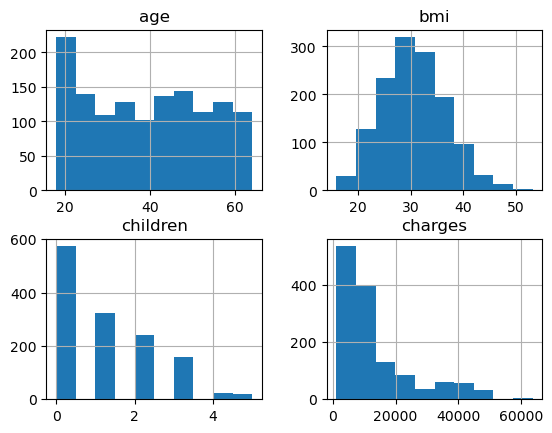

In [5]:
data.hist()

But enough data snipping! We now need to split the dataset into training and validation set, and put the validation set aside. Since there are 1388 records, I will use 200, which is about 21.61% of the dataset as the validation set.

In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=200, random_state=42)

Here I define two *pipeline*, which are used to act as convenient functions to process input features.

In [7]:
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

We preprocess the train set.

In [8]:
train_preprocessed = preprocessing.fit_transform(train)

Convert to a `pd.DataFrame` for the sake of visualization.

In [9]:
train_preprocessed_dataframe = pd.DataFrame(
    train_preprocessed,
    index=train.index,
    columns=preprocessing.get_feature_names_out(),
)
train_preprocessed_dataframe.head()

,pipeline-1__age,pipeline-1__bmi,pipeline-1__children,pipeline-1__charges,pipeline-2__sex_female,pipeline-2__sex_male,pipeline-2__smoker_no,pipeline-2__smoker_yes,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest
1137,-0.940673,-1.357443,-0.900701,-0.837349,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
331,0.906952,-0.519801,-0.900701,0.921679,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
796,-0.656423,2.233149,0.745882,-0.746992,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1039,-1.438110,-0.535313,0.745882,0.764162,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
261,-1.367048,-0.604709,-0.077410,0.315778,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


And check the corelation of each feature with regard to the output feature.

In [10]:
train_preprocessed_dataframe.corr("pearson")["pipeline-1__charges"]

pipeline-1__age                 0.286336
pipeline-1__bmi                 0.200900
pipeline-1__children            0.070097
pipeline-1__charges             1.000000
pipeline-2__sex_female         -0.056761
pipeline-2__sex_male            0.056761
pipeline-2__smoker_no          -0.780530
pipeline-2__smoker_yes          0.780530
pipeline-2__region_northeast   -0.003090
pipeline-2__region_northwest   -0.050548
pipeline-2__region_southeast    0.083205
pipeline-2__region_southwest   -0.032565
Name: pipeline-1__charges, dtype: float64

According to the corelation, the variable with the highest corelation with `charges` is `smoker`, next is `age`, then `bmi`. All other variables don't have noticeable influence on `charges` (correlation < 0.1).

Anh now, we can train a Linear Regression model.

In [11]:
from sklearn.linear_model import LinearRegression

X_train = train.drop("charges", axis=1)
y_train = train["charges"]
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x72c7ed969550>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x72c7ed8cc310>)])),
                ('linearregression', LinearRegression())])

Let's have a look at its coefficients and intercept values.

In [12]:
lin_reg_params = lin_reg.get_params()["linearregression"]
lin_reg_params.coef_, lin_reg_params.intercept_

(array([  3659.54122619,   1994.81298897,    511.85393327,     66.15291417,
           -66.15291417, -11889.34815423,  11889.34815423,    402.18493633,
            73.93161706,   -219.19002854,   -256.92652485]),
 20326.876956193955)

And yes, the linear regression model amplifies our thinking.

Let's look at its error, specifically its root mean squared error (the square root of MSE).

In [13]:
from sklearn.metrics import mean_squared_error

y_predict = lin_reg.predict(X_train)
lin_rmse = mean_squared_error(y_train, y_predict, squared=False)
lin_rmse

6125.35415844748

Now we will perform a t-test to see if the corelation in our data is by pure random chance. There's a catch though: we're doing multiple linear regression, the degree of freedom hence will not be $n-2$, but $n-p-1$, where p is the number of independent variables.

Our null hypothesis $H_0$ here will be there is no corelation, and hence the alternative hypothesis $H_1$ will be there is a correlation. We denote the population correlation coefficient vector (as we have many independent variables, not one) as $\rho$, and the sample correlation coefficient vector as r.
$$H_0: \rho = 0$$
$$H_1: \rho \neq 0$$

Here $0$ is a vector full of zeros. 

In [14]:
# Degree of freedom
n = len(X_train)
num_parameters = X_train.shape[1]
degree_of_freedom = n - num_parameters - 1

# Residuals errors
residuals = y_train - y_predict

# Standard error of the model
standard_error = np.sqrt(np.sum(residuals**2) / degree_of_freedom)

In [15]:
# We need to use preprocessed data
X_train_preprocessed = lin_reg.get_params()["columntransformer"].fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(
    X_train_preprocessed,
    index=X_train.index,
    columns=preprocessing.get_feature_names_out(),
)

# Standard error of coefficients
X_with_intercept = np.c_[
    np.ones((X_train_preprocessed.shape[0], 1)), X_train_preprocessed
]  # add intercept
coef_variances = (
    standard_error**2 * np.linalg.inv(X_with_intercept.T @ X_with_intercept).diagonal()
)
coef_standard_error = np.sqrt(coef_variances)

/tmp/ipykernel_28902/190061657.py:16: RuntimeWarning: invalid value encountered in sqrt
  coef_standard_error = np.sqrt(coef_variances)


Because the fifth and sixth values of `coef_variances` are negative, when taking square root, they become `nan`. This indicates there's a numerical instability happens here with Python. A possibility, which is our case, is where `X_with_intercept.T @ X_with_intercept` is close to singular.

In [16]:
coef_variances

array([ 5.45461759e+20,  3.38276407e+04,  3.64468693e+04,  3.33239208e+04,
       -6.17229527e+21, -6.17229527e+21,  5.71567532e+20,  5.71567532e+20,
        1.13328257e+05,  7.76068061e+04,  1.05023333e+05,  1.19849896e+05])

In [17]:
coef_standard_error

array([2.33551228e+10, 1.83922921e+02, 1.90910632e+02, 1.82548407e+02,
                  nan,            nan, 2.39074786e+10, 2.39074786e+10,
       3.36642625e+02, 2.78579981e+02, 3.24073036e+02, 3.46193437e+02])

Hence I'll explicitly make them a bit larger than zero here, to make them able to be divided later.

In [18]:
coef_standard_error[[4, 5]] = [1e-10, 1e-10]
coef_standard_error

array([2.33551228e+10, 1.83922921e+02, 1.90910632e+02, 1.82548407e+02,
       1.00000000e-10, 1.00000000e-10, 2.39074786e+10, 2.39074786e+10,
       3.36642625e+02, 2.78579981e+02, 3.24073036e+02, 3.46193437e+02])

In [19]:
# t-statistics
t_stats = lin_reg_params.coef_ / coef_standard_error[1:]

# p-values
p_values = [2 * (1 - t(degree_of_freedom).cdf(np.abs(t_stat))) for t_stat in t_stats]

In [20]:
for i in range(X_train_preprocessed.shape[1]):  # number of independent variables
    print(
        f"The p-value of {X_train_preprocessed.columns[i]} is {p_values[i]}\n  and the t-stat is {t_stats[i]}"
    )

The p-value of pipeline-1__age is 0.0
  and the t-stat is 19.897146126880298
The p-value of pipeline-1__bmi is 0.0
  and the t-stat is 10.448936085977204
The p-value of pipeline-1__children is 0.005134653079546636
  and the t-stat is 2.8039353647446412
The p-value of pipeline-2__sex_female is 0.0
  and the t-stat is 661529141706.0062
The p-value of pipeline-2__sex_male is 0.0
  and the t-stat is -661529141706.0082
The p-value of pipeline-2__smoker_no is 0.9999996032943985
  and the t-stat is -4.973066530148917e-07
The p-value of pipeline-2__smoker_yes is 0.9999996032943985
  and the t-stat is 4.973066530148918e-07
The p-value of pipeline-2__region_northeast is 0.23245706644499942
  and the t-stat is 1.1946940350958395
The p-value of pipeline-2__region_northwest is 0.7907594042101893
  and the t-stat is 0.2653874003228499
The p-value of pipeline-2__region_southeast is 0.49895041456122735
  and the t-stat is -0.676359969374524
The p-value of pipeline-2__region_southwest is 0.458152186902

The result above has some problems with it. One problem is here:

In [21]:
pd.DataFrame(
    np.linalg.inv(X_with_intercept.T @ X_with_intercept)
    @ (X_with_intercept.T @ X_with_intercept)
)

,0,1,2,3,4,5,6,7,8,9,10,11
0,8.557010e+15,0.932255,3.289713,-0.090833,4.188273e+15,4.368737e+15,6.812523e+15,1.744487e+15,2.060299e+15,2.082857e+15,2.323476e+15,2.090377e+15
1,-3.709278e-01,0.999029,-0.023337,0.001481,-1.768194e-01,-1.941083e-01,-2.976264e-01,-7.330135e-02,-6.702349e-02,-6.676925e-02,-1.291518e-01,-1.079832e-01
2,9.472740e-02,0.003709,1.024695,-0.001603,3.234759e-02,6.237981e-02,9.689815e-02,-2.170751e-03,-1.067418e-02,1.356008e-03,4.873913e-02,5.530643e-02
3,2.536422e+00,0.000325,0.003065,0.999682,1.239191e+00,1.297231e+00,2.019547e+00,5.168748e-01,6.091223e-01,6.089119e-01,6.902366e-01,6.281511e-01
4,-9.761382e+16,-12.655811,-42.417084,1.709135,-4.777759e+16,-4.983623e+16,-7.771364e+16,-1.990018e+16,-2.350280e+16,-2.376013e+16,-2.650498e+16,-2.384591e+16
5,-9.761382e+16,-12.655811,-44.417084,1.834135,-4.777759e+16,-4.983623e+16,-7.771364e+16,-1.990018e+16,-2.350280e+16,-2.376013e+16,-2.650498e+16,-2.384591e+16
6,8.905681e+16,11.673546,42.256747,-1.648393,4.358932e+16,4.546749e+16,7.090111e+16,1.815569e+16,2.144250e+16,2.167727e+16,2.418151e+16,2.175553e+16
7,8.905681e+16,11.673546,42.256747,-1.773393,4.358932e+16,4.546749e+16,7.090111e+16,1.815569e+16,2.144250e+16,2.167727e+16,2.418151e+16,2.175553e+16
8,5.637045e+00,0.315548,-0.096864,0.117215,3.069959e+00,1.567086e+00,1.147922e+01,1.532821e+00,3.000000e+00,2.000000e+00,2.500000e+00,3.000000e+00
9,5.269455e+00,0.327906,-0.177743,0.120776,2.873937e+00,1.395518e+00,1.122127e+01,1.423182e+00,1.500000e+00,3.000000e+00,2.000000e+00,3.000000e+00


We can't calculate the inverse matrix properly!

See what happen when I use the library `statsmodels`.

In [22]:
import statsmodels.api as sm

X = sm.add_constant(X_train_preprocessed)
model = sm.OLS(y_train, X).fit(use_t=True)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     406.1
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        23:52:42   Log-Likelihood:                -11538.
No. Observations:                1138   AIC:                         2.309e+04
Df Residuals:                    1129   BIC:                         2.314e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           